# Step4 演習04 MNISTの分類
---

本演習では、Kerasを用いてMNISTの分類をおこないます。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での利用は避けてください。

**本演習の目的**
- Kerasを用いて演習01と同じCNNの実装を行う

**【課題１】** 採点を実行してください。

In [1]:
#Coursedele-02 Step4 QuestionNumber13 73fae3b054d083b91d3a570f08cfbcc8
print("この課題の採点は全員正解とします。")

この課題の採点は全員正解とします。


** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [2]:
%%bash
./validation_client.py dele-02 4 13 Step4_04.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



## 2 Keras

## 2-1 ライブラリのインポート

まずはじめに、本演習で利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント
- [tensorflow](https://www.tensorflow.org/) 機械学習用のライブラリの公式ドキュメント
- [keras](https://keras.io/) 機械学習用のライブラリ（tensorflowなどのラッパー）の公式ドキュメント

`%matplotlib inline` はnotebook上で使える[magic function](http://ipython.readthedocs.io/en/stable/interactive/magics.html)の一つで、これによりmatplotlibをインタラクティブに使うことできます。

`keras`を用いることでCNNやRNNを非常に簡単に作ることができるようになります。

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow import keras

## 2-2 データセット
Step4 演習3と同様にMNISTを使います。

In [4]:
# ダウンロード元のURL
mnist_ulr = 'http://yann.lecun.com/exdb/mnist/'

# データの読み込み
mnist = input_data.read_data_sets("MNIST_data/", 
                                  one_hot=True, 
                                  validation_size=0, 
                                  source_url=mnist_ulr)

# データのシャッフル
permutation = np.random.permutation(mnist.train._images.shape[0])
mnist.train._images = mnist.train.images[permutation]
mnist.train._labels = mnist.train.labels[permutation]

#データの正規化
mean = np.mean(mnist.train.images)
std = np.std(mnist.train.images)
mnist.train._images = (mnist.train.images-mean)/std
mnist.test._images = (mnist.test.images-mean)/std

# データセットのサイズを制限
train_size = 10000
test_size = 1000
mnist.train._images = mnist.train.images[:train_size]
mnist.train._labels = mnist.train.labels[:train_size]
mnist.train._num_examples = train_size
mnist.test._images = mnist.test.images[:test_size]
mnist.test._labels = mnist.test.labels[:test_size]
mnist.test._num_examples = test_size

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## 2-3 モデルの構築

**【確認１】**　演習01と全く同じ構造のCNNをKerasで構築します。

- `KL`: 毎回`keras.layers`と書かずに済むようにします。
- `REG`:上記と同様の理由です。これはL2正則化するために必要なものです。引数には1e-4を渡します。
- `model`: kerasの[Sequential](https://keras.io/models/sequential/)という記述法でモデルを作成します。詳しくは[Sequential](https://keras.io/models/sequential/)を読んでください。
この演習ではtensorflowからkerasを読み込んでいるので少しだけサイトとは違う記述をする必要があります。記述法はセルのコメントを読んでください。

まずここで、kerasの[Conv2D](https://keras.io/layers/convolutional/#conv2d), [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d)と[Dense](https://keras.io/layers/core/#dense)について説明します。
- [Conv2D](https://keras.io/layers/convolutional/#conv2d): これには最低限フィルタ数（`filters`）とカーネルサイズ（`kernel_size`）を渡す必要があります。それ以外はデフォルトの値が入っています。例えば、`strides=(1,1)`, `padding='valid'`, `activation=None`, `kernel_initializer='glorot_uniform'` (演習01で使用した初期化方法）となっています。今回は`activation='relu'`, `padding='same'`, `kernel_regularizer=REG`とします。`kernel_size`と`strides`ですが縦横が同じ形であれば`(3,3)`ではなく`3`と書くこともできます
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d): これは引数なしでも使うことができますが、今回はストライド（`strides`）を設定します。フィルタサイズ（`pool_size`）はデフォルトで(2,2)になっているので今回は書かなくても問題ありません。
- [Dense](https://keras.io/layers/core/#dense): これは全結合のことです。ノード数（`units`)を最低限記述する必要があります。今回は、畳み込み層同様に`activation`, `padding`, `kernel_regularizer`を設定してください。

以上が簡単な説明でした。詳細はkerasのドキュメントを読んで確認してください。それでは実際にcnnを構築します。また、shift+tabでデフォルトで設定されている値を確認して見てください。
- [Reshape](https://keras.io/layers/core/#reshape)を使って入力テンソルを（28,28,1）となるように変換します。ここで、`model`の一番始めの層ということで引数に`input=(28*28,)`を渡すようにしてください。
- カーネルサイズ：３、フィルター数：１６、ストライド：１の畳み込み層, 活性関数はReLUとし、重みにL2正則化を追加します。
- フィルターサイズ：２，ストライド：２のプーリング層を追加します。
- カーネルサイズ：３、フィルター数：３２、ストライド：１の畳み込み層, 活性関数はReLUとし、重みにL2正則化を追加します。
- 活性化関数
- 入力テンソルを２Dに変換します。
- ノード数１２８の全結合層, 活性関数はReLUとし、重みにL2正則化を追加します。
- ドロップアウトは0.5とします。
- ノード数１０の全結合層, 活性関数はsoftmaxとし、重みにL2正則化を追加します。

In [6]:
KL = keras.layers
'''
KLからkerasのlayerを取得します。
[例]
KL.Reshape, KL.Conv2D, KL.Maxpooling, KL.Flatten(), KL.Dense(), KL.Dropout()など
'''
REG = keras.regularizers.l2(1e-4)

model = keras.models.Sequential()
###############START CODE HERE###############
#適切な 関数・変数・値 などにNoneを書き換えてください。
model.add(KL.Reshape((28,28,1), input_shape=(28*28,)))
model.add(KL.Conv2D(3, 16, activation='relu', 
                    padding='same',
                    kernel_regularizer=REG))
model.add(KL.MaxPooling2D(strides=2))
model.add(KL.Conv2D(3, 32, activation='relu', 
                    padding='same',
                    kernel_regularizer=REG))
model.add(KL.Flatten())
model.add(KL.Dense(128, activation='relu', 
                   kernel_regularizer=REG))
model.add(KL.Dropout(0.5))
model.add(KL.Dense(10, activation='relu', 
                   kernel_regularizer=REG))
################END CODE HERE################
# セルを実行するとWARNING（警告）がでるかもしれませんが、特に問題はないので無視してください。

次に作成したモデルの構造を確認します。`model.summary()`を見ることで各層の出力サイズとパラメータ数が分かります。

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 3)         771       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 3)         9219      
_________________________________________________________________
flatten_1 (Flatten)          (None, 588)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               75392     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

## 2-4 モデルの準備

**【確認２】**　モデルをコンパイルします。

`model`ができたら次に、ロスや最適化手法を設定し、[compile](https://keras.io/models/sequential/#compile)します。
- `loss`: [categorical_crossentropy](https://keras.io/backend/#categorical_crossentropy)を使用します。
- `optimizer`: [Adam](https://keras.io/optimizers/#adam)を使用します。
- `metrics`: モデルのパフォーマンス評価関数を設定します。今回は`['accuracy']`とします。

In [10]:
# categorical_crossentropyはkeras.losses.categorical_crossentropyと書いてください。
###############START CODE HERE###############
#適切な 関数・変数・値 などにNoneを書き換えてください。
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])
################END CODE HERE################

## 2-5 コールバックの準備

**【確認３】**　ここではコールバックを１つ実装します。

Kerasには[callback](https://keras.io/callbacks/)と呼ばれる関数が用意されています。これは学習時にモデルの内部情報を記録したり、変更したりする際に使用します。今回はモデルのパラメータを自動で保存してくれるコールバックを用意します。そのために、[ModelCheckpoint](https://keras.io/callbacks/#ModelCheckpoint)を用います。

また、Kerasモデルのすべてに[Hisotry](https://keras.io/callbacks/#history)のコールバックがデフォルトで設定されています。

In [11]:
###############START CODE HERE###############
filepath = './weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath)
################END CODE HERE################

ModelChekcpoint以外にも多くのコールバックがKerasには実装されています。時間があればこれ以外のコールバックも追加してみて下さい。

## 2-5学習

では実際に学習を行います。kerasでは[model.fit](https://keras.io/models/sequential/#fit)を使うことで簡単に学習を行うことができます。

In [12]:
%%time
batch_size = 200
total_epoch = 3
log = model.fit(mnist.train.images, mnist.train.labels,
          batch_size=batch_size,
          epochs=total_epoch,
          verbose=1,
          validation_data=(mnist.test.images, mnist.test.labels),
          callbacks=[model_checkpoint])
score = model.evaluate(mnist.test.images, mnist.test.labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10000 samples, validate on 1000 samples
Epoch 1/3
10000/10000 [==============================] - 76s - loss: 3.5955 - acc: 0.1495 - val_loss: 2.1434 - val_acc: 0.3820
Epoch 2/3
10000/10000 [==============================] - 81s - loss: 2.0649 - acc: 0.2870 - val_loss: 1.6090 - val_acc: 0.6540
Epoch 3/3
10000/10000 [==============================] - 80s - loss: 1.8040 - acc: 0.4634 - val_loss: 1.4599 - val_acc: 0.7100
Test loss: 1.459920166015625
Test accuracy: 0.71
CPU times: user 7min 8s, sys: 23 s, total: 7min 31s
Wall time: 4min 2s


`log`には学習の履歴が保存されています。（コールバックのHistory）これを用いて学習ロスとテストロスをプロットしてみます。

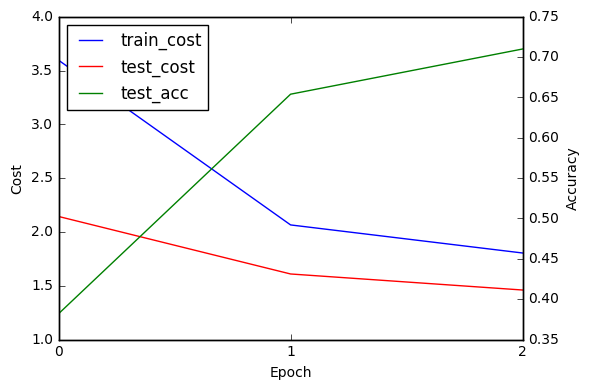

In [13]:
fig, ax1 = plt.subplots()
lns1 = ax1.plot(log.history['loss'], label='train_cost', color='b')
lns2 = ax1.plot(log.history['val_loss'], label='test_cost', color='r')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cost')
ax1.set_xticks(range(total_epoch))

ax2 = ax1.twinx()
lns3 = ax2.plot(log.history['val_acc'], label='test_acc', color='g')
ax2.set_ylabel('Accuracy')

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)
fig.tight_layout()